#**Deep Learning Homework 4: *Recurrent Neural Networks & Transformer***
### MSc Computer Science, Data Science, Cybersecurity @UNIPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti, Prof. Nicolò Navarin and Dr. Luca Pasa
---
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. We will use the IMDB dataset---it contains the text of some reviews and the sentiment given by their authors (either positive or negative). The input to the RNN is the sequence of words that compose a review, so the learning task consists in predicting the overall sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will solve the same classification problem with a Transformer, in order to have a closer look at its internal functioning.

---
##**Important Instructions for Submissions:**

Generally, in the homeworks, you will be either required to complete a part of Python code or to answer questions in text cells. Code and text cells where you are expected to write your answers have been marked by `%STARTCODE` and `%ENDCODE` or `%STARTEXT` and `%ENDTEXT` tags, respectively. Note that you should never change, move or remove these two tags, otherwise your answers will be __not__ valid. As you will see in this notebook, each cell that includes a `[TO COMPLETE]` part has been put between these placeholders. 

#Requirements

In [1]:
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 113.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━

#Imports

In [2]:
import torch
from torch import nn
from torch.nn import Embedding, RNN, LSTM, GRU, Linear, Transformer
import torch.nn.functional as F
from torchinfo import summary
from torchtext.datasets import IMDB
from torch.utils.data import DataLoader, Dataset, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision.transforms import Lambda
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
rng = np.random.default_rng(seed=4242)

#Data Loading and Preprocessing

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). As usual, for speed and efficiency, we will use only a subset of the dataset. Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. We load the data from the PyTorch database and then split the data into train, validation and test set. 

In [3]:
train, test = IMDB(root="dataset", split=('train', 'test'))
Tr, Ts = list(train), list(test)
rng.shuffle(Tr)
rng.shuffle(Ts)
len_train, len_val, len_test = 25000, 12500, 12500 # Whole data
train_data, val_data, test_data = Tr[:len_train], Ts[:len_val], Ts[len_val:len_val+len_test]

In [ ]:
len(train_data), len(val_data), len(test_data)

(25000, 12500, 12500)

In [4]:
idx = 10
label_samp, text_samp = train_data[idx]
print(f"text: {text_samp}")
print(f"label: {label_samp}")

text: Assuming this won't end up a straight-to-video release, I would have to say void this title at all costs. Unless you're bored of good, well-executed movies, that is. I saw this last night at AFI Dallas, and I left with 20 minutes remaining, simply because I didn't care anymore (about the plot, not about insulting the director...that is awkward). When you can spot a goof only 5 minutes into the movie (a shot out, shattered window before any shots are fired...and then the window breaks with the first shot), things are going to bad. Let's just say this is only an indicator of things to come...unfortunately.<br /><br />I'll spare you all the details, but this is sub-par in every manner, even the half-assed acting by Michael Madsen is disappointing when you're expecting half-assed acting from him. And the rape scene...Christ! "Shut up and take it" should never be used in a rape scene. EVER.<br /><br />3/10
label: 1


Let's check the dataset statistics.

In [5]:
datasets = {'train':train_data, 'val':val_data, 'test':test_data}
for key in datasets:
  label_dist = {}
  dataset = datasets[key]
  for lb, txt in dataset:
    if lb not in label_dist:
      label_dist.setdefault(lb, 1)
    else:
      label_dist[lb] += 1
  print(f"{key}:")
  print(label_dist)


train:
{1: 12500, 2: 12500}
val:
{2: 6245, 1: 6255}
test:
{2: 6255, 1: 6245}


In [6]:
tokenizer = get_tokenizer('basic_english')

def create_tokens(dataset):
  for sample in dataset:
    yield tokenizer(sample[1])

vocab = build_vocab_from_iterator(create_tokens(train_data), specials=["<oov>", "<sos>"], max_tokens=10000)
vocab.set_default_index(vocab["<oov>"])
print(f"Our vocabulary is made of {len(vocab)} tokens-index pairs.")

Our vocabulary is made of 10000 tokens-index pairs.


In [7]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [ ]:
print(vocab.get_itos())  # top 10000 freq words (including special chars)

['<oov>', '<sos>', 'the', '.', ',', 'and', 'a', 'of', 'to', "'", 'is', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', ')', '(', 'you', 't', 'on', 'not', 'he', 'are', 'his', 'have', 'be', 'one', '!', 'all', 'at', 'they', 'by', 'an', 'who', 'from', 'so', 'like', 'there', 'her', 'or', 'just', 'about', 'if', 'has', 'out', 'what', '?', 'some', 'good', 'can', 'more', 'when', 'she', 'very', 'even', 'my', 'no', 'up', 'would', 'time', 'which', 'only', 'story', 'really', 'their', 'see', 'had', 'we', 'were', 'me', 'than', 'well', 'much', '-', 'get', 'been', 'people', 'will', 'also', 'other', 'bad', 'into', 'do', 'because', 'great', 'first', 'how', 'him', 'don', 'most', 'its', 'made', 'then', 'them', 'way', 'could', 'make', 'too', 'any', 'after', 'movies', 'think', 'characters', 'character', 'watch', 'films', 'two', 'many', 'seen', 'being', 'never', 'little', 'plot', 'acting', 'where', 'best', 'love', 'did', 'life', 'show', 'know', 'does', 'ever', 'here',

In [8]:
word_index = {k:v for (k, v) in enumerate(vocab.get_itos())}

In [9]:
def decode_review(word_ids):
    return " ".join([word_index.get(word_id, "<err>") for word_id in word_ids])

print(text_samp)
print("\n")
print(decode_review(text_pipeline(text_samp)))

Assuming this won't end up a straight-to-video release, I would have to say void this title at all costs. Unless you're bored of good, well-executed movies, that is. I saw this last night at AFI Dallas, and I left with 20 minutes remaining, simply because I didn't care anymore (about the plot, not about insulting the director...that is awkward). When you can spot a goof only 5 minutes into the movie (a shot out, shattered window before any shots are fired...and then the window breaks with the first shot), things are going to bad. Let's just say this is only an indicator of things to come...unfortunately.<br /><br />I'll spare you all the details, but this is sub-par in every manner, even the half-assed acting by Michael Madsen is disappointing when you're expecting half-assed acting from him. And the rape scene...Christ! "Shut up and take it" should never be used in a rape scene. EVER.<br /><br />3/10


assuming this won ' t end up a straight-to-video release , i would have to say void

To keep the length of the all the input sequences same, we define the padding function. All the sentence less than the lenght of 500 will be padded with zeros and greater than 500 will be truncated. Notice that we will pad and truncate sequences right-wise, so that processing the sequences, the final hidden states of the recurrent networks will correspond to the final words of each sequence in the batch.



In [10]:
def sent_padding(sent_vec, maxlen):
  sent_vec = torch.tensor(sent_vec)
  maxlen -= len(sent_vec)
  return F.pad(sent_vec, (maxlen, 0))


print(sent_padding([1,2,3], maxlen=6))
print(sent_padding([1,2,3,4,5,6,7,8,9], maxlen=6))

tensor([0, 0, 0, 1, 2, 3])
tensor([4, 5, 6, 7, 8, 9])


In [11]:
seq_len = 500
sent_padding(text_pipeline(text_samp), maxlen=seq_len)

tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
class CustomDataset(Dataset):
  
  def __init__(self, dataset, seq_len=seq_len):
    super().__init__()
    self.dataset = dataset
    self.seq_len = seq_len
  
  def __len__(self):
    return len(self.dataset) 
  
  def __getitem__(self, idx):
    label, text = self.dataset[idx]
    label = label_pipeline(label)
    txt_rep = sent_padding(text_pipeline(text), maxlen=self.seq_len)
    label, txt_rep = torch.tensor(label, dtype=torch.float32), torch.tensor(txt_rep, dtype=torch.long)
    return label.to(device), txt_rep.to(device)

In [14]:
train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)
test_dataset = CustomDataset(test_data)

In [15]:
batch_size=256
dataloader_training = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_dataset, batch_size=batch_size)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size)

#Model Definition

Let's define the model: 
- The first layer is an Embedding layer, with input_dim=vocab_dim and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) 
- The output layer 

### Model Comparison

In order to perform a fair comparison of the models RNN, LSTM and GRU make sure they use more or less the same number of parameters.

In the next cell, we define our simple RNN used for binary classification. The class has two main methods, the constructor (`init()`) and the `forward()` method.

In the constructor, the input parameters are used to define the layers and hyperparameters of the RNN. The layers that are defined include an embedding layer (`self.embedding`), a recurrent layer (`self.rnn`), and a linear layer (`self.linear`). The constructor also sets up various parameters such as the embedding input size, the embedding output size, the hidden size, the number of layers, the batch size, the RNN type, and whether or not the RNN is bidirectional.

The `forward()` method takes a batch of input data (`x`) and applies the layers defined in the constructor in a specific sequence. First, the input is passed through the embedding layer to create embeddings of the input tokens. These embeddings are then permuted to be of the correct shape for the RNN layer, which expects inputs of the form (`seq_len, batch_size, H_in`). The RNN layer is then applied to these embeddings, producing both the RNN output (`rnn_out`) and the last hidden state (`self.last_hidden`). Finally, the output of the RNN is passed through a linear layer and flattened to produce the final output of the network, which is a sigmoid activation function applied to a tensor of shape (`batch_size`). This output is then returned.

In [ ]:
class My_RNN(nn.Module):
  def __init__(self, vocab_length, emb_dim, hidden_size, num_layers,
               batch_size, RNN_type, bidirectional, device=device):
    super().__init__()
    self.emb_in_dim = vocab_length  # 10000
    self.emb_out_dim = emb_dim  # 10
    self.hidden_size = hidden_size 
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.batch_size = batch_size
    self.RNN_type = RNN_type
    self.target_size = 1  # binary classification
    self.device = device
    self.D = 2 if self.bidirectional else 1  # enable/disable bidirectional
    
    valid_types = {'Simple RNN':RNN, 'LSTM':LSTM, 'GRU':GRU}
    assert self.RNN_type in valid_types.keys(), f'You must choose one of {valid_types.keys()} types'
    
    self.embedding = Embedding(self.emb_in_dim, self.emb_out_dim) 
    
    chosen_rnn = valid_types[self.RNN_type]
    self.rnn = chosen_rnn(input_size=self.emb_out_dim, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, bidirectional = self.bidirectional)
    
    self.linear = Linear(self.D*self.hidden_size, self.target_size)

  def forward(self, x):
    #x: (batch_size, 500)
    self.embeds = self.embedding(x)
    #embeds: (batch_size, 500, 10)
    #But rnn receives inputs of: (500, batch_size, 10) (seq_len, batch_size, H_in)
    self.embeds = self.embeds.permute(1, 0, 2)
    #embeds: (500, batch_size, 10) -> Now the shape is correct
    rnn_out, self.last_hidden = self.rnn(self.embeds)
    #rnn_out: (500, 256, 2*5:10) -> (seq_len, batch_size, D*hidden_size)
    #h_n: (1, 256, hidden_size) -> (D*num_layers, batch_size, hidden_size)
    output = self.linear(rnn_out[-1, :, :])
    #output: (256, 1) -> (batch_size, target_size)
    output = output.flatten()
    #output: (256) -> (batch_size)
    return F.sigmoid(output)

### [TO COMPLETE] Simple RNN

We define a RNN model and evaluate its performance. Your task is to choose the right loss function and motivate your choice. 



`%STARTEXT`

ANSWER: **TO COMPLETE**

I chose Binary Cross-Entropy Loss, because we are dealing with a binary classification task. And usually it is the loss function to be [evaluated first](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/) and only changed if we have a good reason.

`%ENDTEXT`

`%STARTCODE`

In [ ]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'Simple RNN' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 10
lr = 1e-3

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = nn.BCELoss()    
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─RNN: 1-2                               1,408
├─Linear: 1-3                            33
Total params: 101,441
Trainable params: 101,441
Non-trainable params: 0

`%ENDCODE`

Now we can train our model. Try to grasp how a training loop is defined in PyTorch and what each line does!

In [ ]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()
      
      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 51.50%, Loss: 0.69147795 ---------------- Val_Acc: 52.65%, Val_Loss: 0.69003683
epoch: 2 -> Accuracy: 54.16%, Loss: 0.68723685 ---------------- Val_Acc: 53.42%, Val_Loss: 0.68710530
epoch: 3 -> Accuracy: 55.92%, Loss: 0.68073738 ---------------- Val_Acc: 54.47%, Val_Loss: 0.68293107
epoch: 4 -> Accuracy: 57.70%, Loss: 0.67351252 ---------------- Val_Acc: 54.11%, Val_Loss: 0.68463320
epoch: 5 -> Accuracy: 59.61%, Loss: 0.66364449 ---------------- Val_Acc: 62.85%, Val_Loss: 0.64913028
epoch: 6 -> Accuracy: 61.63%, Loss: 0.65211332 ---------------- Val_Acc: 60.66%, Val_Loss: 0.65966600
epoch: 7 -> Accuracy: 64.96%, Loss: 0.62630439 ---------------- Val_Acc: 64.94%, Val_Loss: 0.63114375
epoch: 8 -> Accuracy: 62.31%, Loss: 0.64429700 ---------------- Val_Acc: 59.47%, Val_Loss: 0.66068459
epoch: 9 -> Accuracy: 65.87%, Loss: 0.61489540 ---------------- Val_Acc: 67.06%, Val_Loss: 0.60913128
epoch: 10 -> Accuracy: 70.88%, Loss: 0.56659496 ---------------- Val_Acc: 69.46%, 

It's time to plot the results...

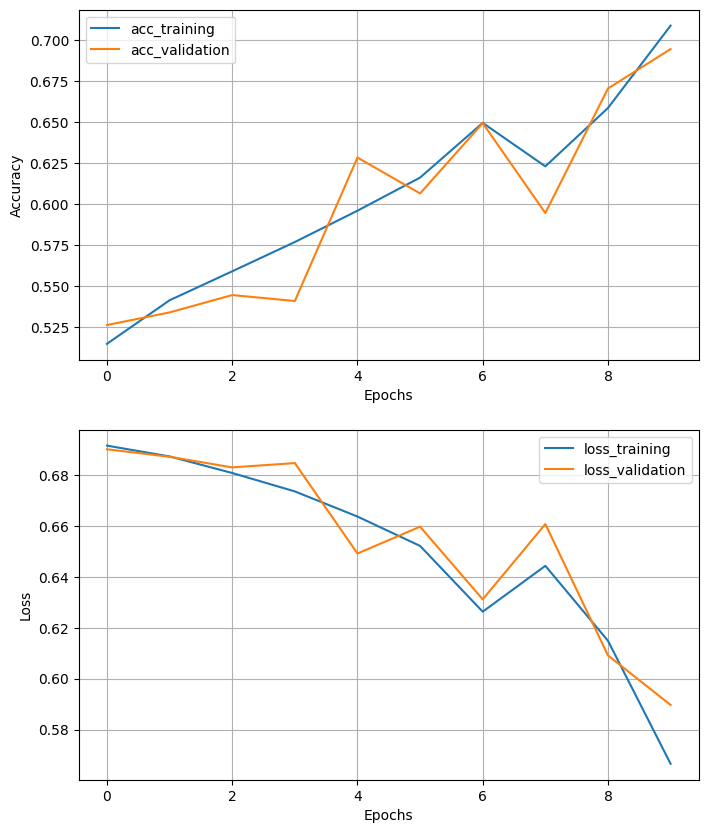

In [ ]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(EPOCHS), acc_tr, label='acc_training')
    plt.plot(range(EPOCHS), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(EPOCHS), loss_tr, label='loss_training')
    plt.plot(range(EPOCHS), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

...and see the performances on the test set:

In [ ]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (label, text) in enumerate(dataloader_test):
      pre_label = model(text)
      loss += criterion(pre_label, label)
      labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
      pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
      total_acc_test += (pre_label == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

In [ ]:
test(model)

Test Loss: 0.58736879 ---------- Test Accuracy: 69.4960%


We should achieve ~60% accuracy on test set. Lets see if we can improve further!

### [TO COMPLETE] LSTM

In this Exercise, you have to implement [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) model, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM layer. Print the model summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

`%STARTCODE`

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─LSTM: 1-2                              5,632
├─Linear: 1-3                            33
Total params: 105,665
Trainable params: 105,665
Non-trainable params: 0
epoch: 1 -> Accuracy: 52.51%, Loss: 0.69062614 ---------------- Val_Acc: 54.01%, Val_Loss: 0.68752551
epoch: 2 -> Accuracy: 56.48%, Loss: 0.67976350 ---------------- Val_Acc: 59.19%, Val_Loss: 0.66927141
epoch: 3 -> Accuracy: 63.18%, Loss: 0.64185280 ---------------- Val_Acc: 65.98%, Val_Loss: 0.61863220
epoch: 4 -> Accuracy: 69.23%, Loss: 0.58724761 ---------------- Val_Acc: 71.44%, Val_Loss: 0.56146455
epoch: 5 -> Accuracy: 74.23%, Loss: 0.53139073 ---------------- Val_Acc: 74.52%, Val_Loss: 0.52903205
epoch: 6 -> Accuracy: 77.52%, Loss: 0.48163101 ---------------- Val_Acc: 77.45%, Val_Loss: 0.49197453
epoch: 7 -> Accuracy: 79.72%, Loss: 0.45037112 ---------------- Val_Acc: 79.16%, Va

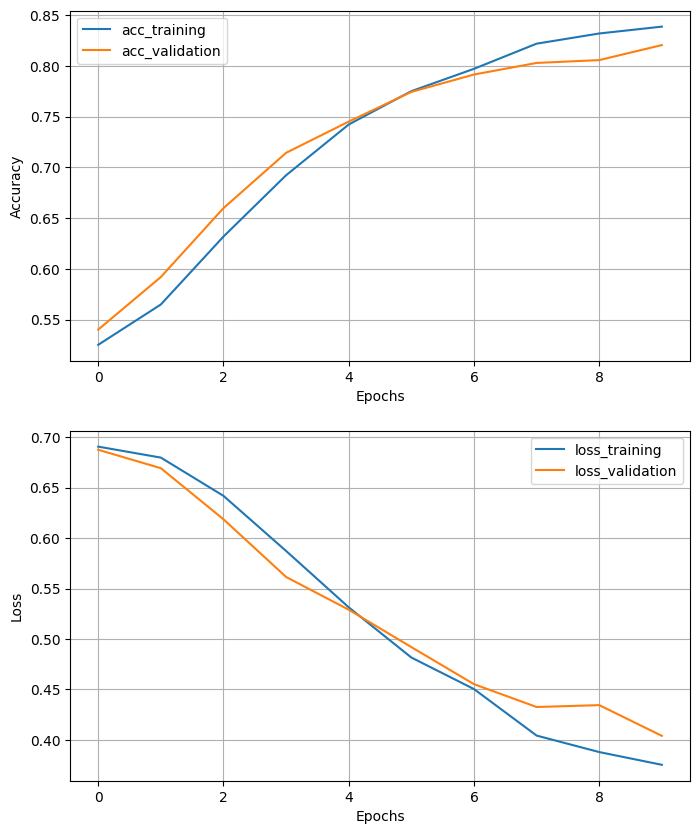

Test Loss: 0.40128595 ---------- Test Accuracy: 82.0160%


In [ ]:
# [TO COMPLETE]

vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'LSTM' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 10
lr = 1e-3

lstm_model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)
print(summary(lstm_model))

criterion = nn.BCELoss()    
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(lstm_model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

test(lstm_model)

`%ENDCODE`

`%STARTEXT`

ANSWER: **TO COMPLETE** Discussion of the results

**Number of parameters discussion:**

*   Embedding layer: The Embedding layer is used to create dense word vectors for incoming words (we project the words into a continuous vector space). This layer sits between the input and the RNN/LSTM layer, i.e., the output of the Embedding layer is the input to the RNN/LSTM layer.
        num_params= vocabulary length x word vector dimension
        num_params = 10,000 x 10 = 100,000
*   Depending on the RNN_type we get either a RNN  or LSTM layer.
    *   RNN Layer: The RNN layer processes sequences of data using recurrent connections.

      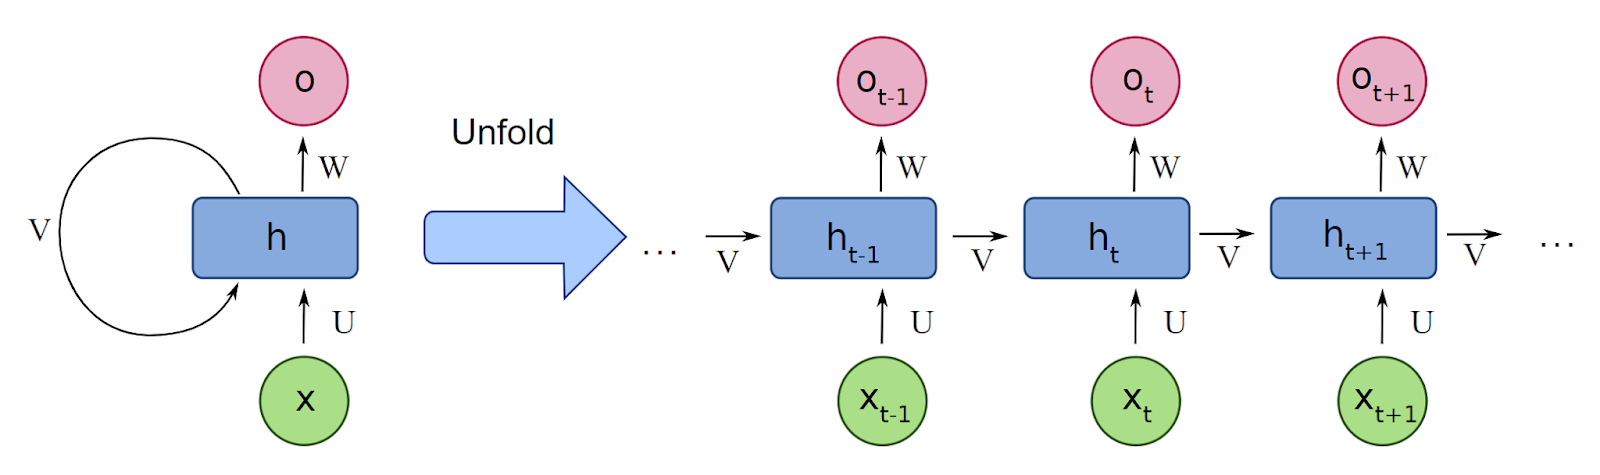
            input size = 10 (output size of the embedding layer)
            num_params = dim(U) + dim(W) + dim(V) + bias
            num_params = (input_size x hidden_size) + (hidden_size x hidden_size) + (hidden_size x output_size) + bias
            num_params = 10 x 32 + 32 x 32 + 32 x 1 + 32 = 1,408
  *   LSTM layer: The LSTM layer is a recurrent layer that captures sequential dependencies in the data. The number of parameters depends on the input size, hidden size, number of gates and bias terms involved. In our case:
            number of gates = 4 (input gate, block input gate, forget gate and output gate)
      The rest of the architecture is the same as before. So, the number of parameters would be 4 times the number of parameters of the RNN layer:
            num_params = 4 x 1,408 = 5,632
*   Linear layer: The linear layer is the final layer of the model, which maps the output of the RNN/LSTM layer to a single output value for binary classification. 
        num_params = hidden_size x output_size + output_size
        num_params = 32 x 1 + 1 = 33

**Training time discussion:**

Training time in second:
*   RNN: 142.773829929
*   LSTM: 152.89396784200005

As we can see, training the LSTM took longer than training the RNN. And this is generally true, because LSTM networks have more complex internal operations and additional parameters compared to simple RNNs.
LSTMs have gate mechanisms that enable them to capture and store long-term dependencies, but these mechanisms involve more computations and therefore require more time for training.

**Performance discussion:**

 The LSTM network performed much better, because of the same reasons explained above (Total params: 101,441 vs Total params: 105,665):
*   RNN: Test Loss: 0.58736879 ---------- Test Accuracy: 69.4960%
*   LSTM: Test Loss: 0.40128595 ---------- Test Accuracy: 82.0160%


`%ENDTEXT`

### [TO COMPLETE] GRU

In this Exercise, you have to implement [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html) model, similar to the previous one that, instead of exploiting the RNN layer, use an GRU layer. Print the model summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

`%STARTCODE`

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─GRU: 1-2                               4,224
├─Linear: 1-3                            33
Total params: 104,257
Trainable params: 104,257
Non-trainable params: 0
epoch: 1 -> Accuracy: 52.46%, Loss: 0.69092631 ---------------- Val_Acc: 53.85%, Val_Loss: 0.68748599
epoch: 2 -> Accuracy: 57.52%, Loss: 0.67556310 ---------------- Val_Acc: 59.12%, Val_Loss: 0.66686618
epoch: 3 -> Accuracy: 66.35%, Loss: 0.61435443 ---------------- Val_Acc: 68.97%, Val_Loss: 0.59275824
epoch: 4 -> Accuracy: 73.94%, Loss: 0.52835917 ---------------- Val_Acc: 74.75%, Val_Loss: 0.52113807
epoch: 5 -> Accuracy: 78.29%, Loss: 0.46702492 ---------------- Val_Acc: 78.22%, Val_Loss: 0.46800315
epoch: 6 -> Accuracy: 80.86%, Loss: 0.42463335 ---------------- Val_Acc: 79.98%, Val_Loss: 0.43838805
epoch: 7 -> Accuracy: 83.12%, Loss: 0.38969755 ---------------- Val_Acc: 81.47%, Va

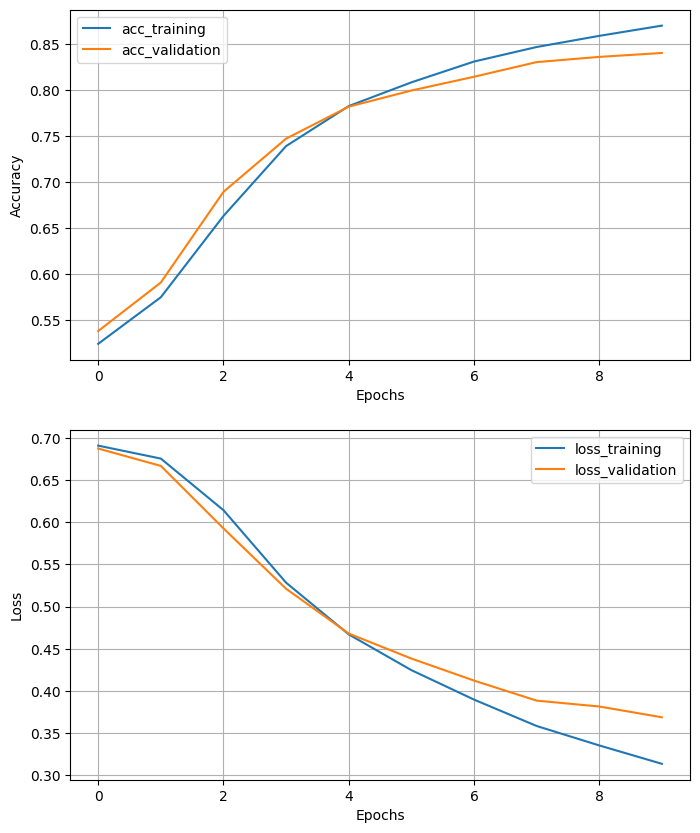

Test Loss: 0.36729556 ---------- Test Accuracy: 84.3360%


In [ ]:
# [TO COMPLETE]

vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'GRU' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 10
lr = 1e-3

gru_model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)
print(summary(gru_model))

criterion = nn.BCELoss()    
optimizer = torch.optim.Adam(gru_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(gru_model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

test(gru_model)

`%ENDCODE`

`%STARTEXT`

ANSWER: **TO COMPLETE** Discussion of the results

1.   RNN
  *   Total params: 101,441 (1,408 in the RNN layer)
  *   Test Loss: 0.58736879 ---------- Test Accuracy: 69.4960%
  *   Training time in second: 142.773829929
2.   LSTM
  *   Total params: 105,665 (5,632 in the LSTM layer)
  *   Test Loss: 0.40128595 ---------- Test Accuracy: 82.0160%
  *   Training time in second:152.89396784200005
3.   GRU
  *   Total params: 104,257 (4,224 in the GRU layer)
  *   Test Loss: 0.36729556 ---------- Test Accuracy: 84.3360%
  *   Training time in second: 163.18001176999996


The number of parameters in the Embedding and Linear layers remains the same across all models, including the RNN, LSTM, and GRU. The only difference is the GRU layer. As we can see, the number of parameters is less than the LSTM but more than the RNN. However, the GRU model shows the best performance: **highest test accuracy**, with **low training time** (lower than LSTM).

Results explanation by theory:

*   GRUs are computationally more efficient and train faster than LSTMs due to their less complex architecture.

*   GRUs tend to perform better than LSTMs (generally this is not true) when the available training data is limited, especially in language modeling tasks. The GRU's simpler architecture allows it to generalize well with fewer training examples, making it effective in scenarios where the dataset size is small.

`%ENDTEXT`

#BiDirectional

Let's also have a look at the performances of a bidirectional LSTM instead of a simple LSTM. Try to understand what is the difference with respect to the previous model and use again the same loss you used before. This is just an extra model, so it will not be graded.


In [ ]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'LSTM' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = True

EPOCHS = 15
lr = 3e-4

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = nn.BCELoss() # COMPLETE
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─LSTM: 1-2                              11,264
├─Linear: 1-3                            65
Total params: 111,329
Trainable params: 111,329
Non-trainable params: 0

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 53.60%, Loss: 0.69064134 ---------------- Val_Acc: 54.39%, Val_Loss: 0.68953955
epoch: 2 -> Accuracy: 55.77%, Loss: 0.68614888 ---------------- Val_Acc: 55.54%, Val_Loss: 0.68454593
epoch: 3 -> Accuracy: 58.81%, Loss: 0.67132670 ---------------- Val_Acc: 58.80%, Val_Loss: 0.66848105
epoch: 4 -> Accuracy: 61.73%, Loss: 0.65322214 ---------------- Val_Acc: 60.98%, Val_Loss: 0.65545559
epoch: 5 -> Accuracy: 63.38%, Loss: 0.64137954 ---------------- Val_Acc: 63.19%, Val_Loss: 0.64187646
epoch: 6 -> Accuracy: 65.49%, Loss: 0.62624776 ---------------- Val_Acc: 64.62%, Val_Loss: 0.63071942
epoch: 7 -> Accuracy: 67.08%, Loss: 0.61160403 ---------------- Val_Acc: 66.35%, Val_Loss: 0.61506069
epoch: 8 -> Accuracy: 68.96%, Loss: 0.59219521 ---------------- Val_Acc: 67.20%, Val_Loss: 0.60505831
epoch: 9 -> Accuracy: 70.20%, Loss: 0.57713276 ---------------- Val_Acc: 69.71%, Val_Loss: 0.58393508
epoch: 10 -> Accuracy: 72.06%, Loss: 0.55608118 ---------------- Val_Acc: 71.30%, 

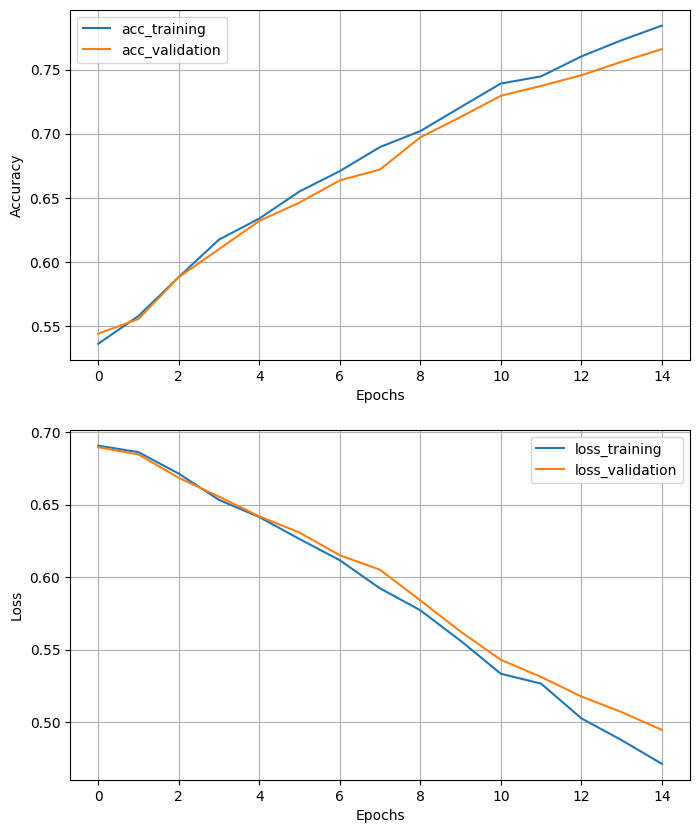

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [ ]:
test(model)

Test Loss: 0.48468432 ---------- Test Accuracy: 77.2160%


# Explore relations between words

We will now quickly explore the properties of the embeddings learned by the model. Each embedding encodes the meaning of a word inferring it from the way it is used in the dataset. One possible way to explore the meaning encoded in the embeddings is check whether analogies that we make between concepts are reflected also in the embeddings as geometric properties. In particular, we will compute the difference between the embeddings of two related words, thus encoding their relation in a vector. Then, we will compute the same measure between a few couples of vectors and check if the couple which has the most similar measure corresponds to words that have the same kind of relation as the first ones. You can try different couples of words, and you may find out that sometimes the encoding of words meanings is the one we might expect - that's why carefully choosing the training data is very important!

In [ ]:
def word_embedder(word):
  word_high_dim = sent_padding(text_pipeline(word), maxlen=seq_len).to(device)
  word_low_dim_embedded = model.embedding(word_high_dim)[-1]
  return word_low_dim_embedded

EMB_VOCAB = {}
for word in vocab.get_itos():
  EMB_VOCAB[word] =  word_embedder(word)

In [ ]:
def cosine_similarity(u, v):
    return torch.dot(u,v) / (torch.sqrt(torch.sum(u * u)) * torch.sqrt(torch.sum(v * v)))

def word_matcher(ref1, ref2, tgt3, candidates, EMB_VOCAB):
  max_thr = -np.inf
  e_ref1, e_ref2, e_tgt3 = EMB_VOCAB[ref1], EMB_VOCAB[ref2], EMB_VOCAB[tgt3]
  for w in candidates:
    e_w = EMB_VOCAB[w]
    sim = cosine_similarity(e_ref2 - e_ref1, e_w - e_tgt3)
    if sim > max_thr:
      result = w
      max_thr = sim
  return result

w1, w2, w3 = 'man', 'woman', 'king'
w4_cand = ['soldier', 'queen', 'prophet']
w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

w1, w2, w3 = 'germany', 'berlin', 'italy'
w4_cand = ['spain', 'rome', 'germany', 'france']
w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

The relation between man -> woman is like the realtion between king -> queen
The relation between germany -> berlin is like the realtion between italy -> spain


### [TO COMPLETE] Transformer

Let's now use a [Transformer](https://arxiv.org/abs/1706.03762) to perform the same task considered in the previous exercise. 

The structure of the transformer is defined as follows:
*   A multi-head attention layer
*   Dropout operation (`dropout_att`)
*   Layer Normalization (`layernorm_att`)
*   A feedforward Neural Network, Sequential, and Dense layer
*   Dropout operation (`dropout_fnn`)
*   Layer Normalization (`layernorm_fnn`) that has in input the summation of the attention layer output and the feedforward NN output

Your task is to experiment with different hyperparameters values and try to find a configuration of the Transformer that can beat the RNNs. In the cell below, write a short comment on the impact of each hyperparameter on model performance according to your observations.

`%STARTEXT`

ANSWER: **[TO COMPLETE]**

The hyper parameters in the transformer model have different effects on its performance:

*   **d_model**: is the token embedding size, i.e., the dimensionality of the representations used as input to the multi-head attention. ***Increasing the value of d_model improved the performance of the model, but it also increased the training time. The highest value before reaching CUDA out of memory error was the value that I kept (16).***

*   **nhead**: defines the number of attention heads in the multi-head attention mechanism of the transformer. Increasing its value allows the model to attend to different parts of the input simultaneously and learn more diverse representations. It's important to notice that ***the value of d_model has to be divisible by the value of nhead. I tried the values of 1, 2, 3 and 4, with different values for d_model. But in the end, having a higher value of d_model turned to be more effective than a higher nhead value. So I kept the value of nhead to 2, which was the highest possible value for nhead, while keeping d_model as 16 and not throwing OutOfMemoryError.***

*   **num_encoder_layers**: This parameter defines the number of encoder layers in the transformer. With more layers, the model has a higher capacity for learning higher-level abstractions from the input, which helps when handling complex input patterns. ***Increasing its value increased the computational cost and the risk of overfitting (especially when having less training data). I tried the values of 1, 2 and 4.***

*   **num_decoder_layers**: This parameter defines the number of decoder layers in the transformer. Similar to the encoder layers, more decoder layers allow the model to capture deeper interactions during the decoding process. ***The number of decoder layers is typically the same as the number of encoder layers, so I also tried the values 1, 2 and 4 (paired with the same value for the encoder). I noticed that this parameter had the highest influence on overfitting.***

Final discussion:

**The model chosen below is the best performing one that I found. "OutOfMemoryError: CUDA out of memory" was a common error when trying more complex configurations. It's worth noting that the selected model shows a slight overfitting tendency. Even though it performed well on the test dataset, the gap between training and validation starts to increase after the 4th epoch. However, to make a better observation more epochs are needed.**


`%ENDTEXT`

In [16]:
new_seq_len = 200
train_dataset_trns = CustomDataset(train_data, seq_len=new_seq_len)
val_dataset_trns = CustomDataset(val_data, seq_len=new_seq_len)
test_dataset_trns = CustomDataset(test_data, seq_len=new_seq_len)

batch_size=256
dataloader_training_trns = DataLoader(train_dataset_trns, batch_size=batch_size, shuffle=True)
dataloader_validation_trns = DataLoader(val_dataset_trns, batch_size=batch_size)
dataloader_test_trns = DataLoader(test_dataset_trns, batch_size=batch_size)

In [17]:
class My_Transform(nn.Module):
  def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, layer_norm_eps, device=device):
    super().__init__()
    self.device = device

    self.emb_en = Embedding(num_embeddings=len(vocab), embedding_dim=d_model)
    self.emb_de = Embedding(num_embeddings=2, embedding_dim=d_model)
    #2: because of binary classification

    self.transformer = Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
                                   num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward,
                                   dropout=dropout, layer_norm_eps=layer_norm_eps)
    
    self.linear = Linear(d_model, 1)#1: because of binary classification

  def forward(self, x, y):

    #x: (batch_size, seq_len) -> (256, 200)
    #y: (batch_size) -> (256)

    y = torch.roll(y, shifts=1, dims=0) #right shifted

    self.embedded_src = self.emb_en(x)
    #self.embedded_src: (batch_size, seq_len, d_model) -> (256, 200, 5)

    '''
    Transformer requires src_dim and trg_dim of (S, N, E)
    (S, N, E) -> (Seq_len, Batch_size, Embed_dim) -> (seq_len, batch_size, d_model)
        - self.embedded_src must be permuted
        - self.embedded_trg must be reshaped accordingly
    Transformer will produce an output of dim (T, N, E)
    (T, N, E) -> (Target_len, Batch_size, Embed_dim) -> (1, batch_size, d_model)
    '''
    
    self.embedded_src = self.embedded_src.permute(1, 0, 2)
    #self.embedded_src: (seq_len, batch_size, d_model) -> (200, 256, 5)
    self.embedded_trg = self.emb_de(y.unsqueeze(0).long()) 
    #self.embedded_trg: (seq_len:target_len, batch_size, d_model) -> (1, 256, 5)

    trns_out = self.transformer(self.embedded_src, self.embedded_trg)
    #trns_out: (target_len, batch_size, d_model) -> (1, 256, 5)

    out = self.linear(trns_out)
    #out: (1, 256, 1)

    return F.sigmoid(out.squeeze()) #(batch_size) -> (256) : Like y

`%STARTCODE`

In [25]:
d_model= 16 #[TO COMPLETE]
nhead= 2 #[TO COMPLETE]                  
num_encoder_layers= 2 #[TO COMPLETE]     
num_decoder_layers= 2 #[TO COMPLETE]     
dim_feedforward=128
dropout=0.1
layer_norm_eps=1e-5

EPOCHS = 10
lr = 1e-3

transformer = My_Transform(d_model, nhead, num_encoder_layers, num_decoder_layers,
                           dim_feedforward, dropout, layer_norm_eps).to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=lr)

summary(transformer)

Layer (type:depth-idx)                                                 Param #
My_Transform                                                           --
├─Embedding: 1-1                                                       160,000
├─Embedding: 1-2                                                       32
├─Transformer: 1-3                                                     --
│    └─TransformerEncoder: 2-1                                         --
│    │    └─ModuleList: 3-1                                            10,784
│    │    └─LayerNorm: 3-2                                             32
│    └─TransformerDecoder: 2-2                                         --
│    │    └─ModuleList: 3-3                                            13,024
│    │    └─LayerNorm: 3-4                                             32
├─Linear: 1-4                                                          17
Total params: 183,921
Trainable params: 183,921
Non-trainable params: 0

`%ENDCODE`

In [26]:
def train_trns(model, optimizer, dataloader_train, dataloader_val, epochs=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):

      optimizer.zero_grad()
      logits = model(text, label)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()
      
      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):

            logits = model(text, label)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [27]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train_trns(transformer, optimizer, dataloader_training_trns, dataloader_validation_trns, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 52.28%, Loss: 0.69208133 ---------------- Val_Acc: 64.89%, Val_Loss: 0.65127349
epoch: 2 -> Accuracy: 68.15%, Loss: 0.60072869 ---------------- Val_Acc: 74.14%, Val_Loss: 0.52864558
epoch: 3 -> Accuracy: 75.68%, Loss: 0.51092082 ---------------- Val_Acc: 78.42%, Val_Loss: 0.46781769
epoch: 4 -> Accuracy: 80.61%, Loss: 0.43404680 ---------------- Val_Acc: 80.73%, Val_Loss: 0.42529225
epoch: 5 -> Accuracy: 83.11%, Loss: 0.38939786 ---------------- Val_Acc: 82.46%, Val_Loss: 0.39599207
epoch: 6 -> Accuracy: 85.07%, Loss: 0.35203272 ---------------- Val_Acc: 83.18%, Val_Loss: 0.37791917
epoch: 7 -> Accuracy: 86.50%, Loss: 0.32610232 ---------------- Val_Acc: 84.51%, Val_Loss: 0.35434392
epoch: 8 -> Accuracy: 87.53%, Loss: 0.30311340 ---------------- Val_Acc: 84.95%, Val_Loss: 0.34983346
epoch: 9 -> Accuracy: 88.46%, Loss: 0.28398809 ---------------- Val_Acc: 85.03%, Val_Loss: 0.35156634
epoch: 10 -> Accuracy: 89.24%, Loss: 0.26735377 ---------------- Val_Acc: 85.17%, 

`%STARTCODE`

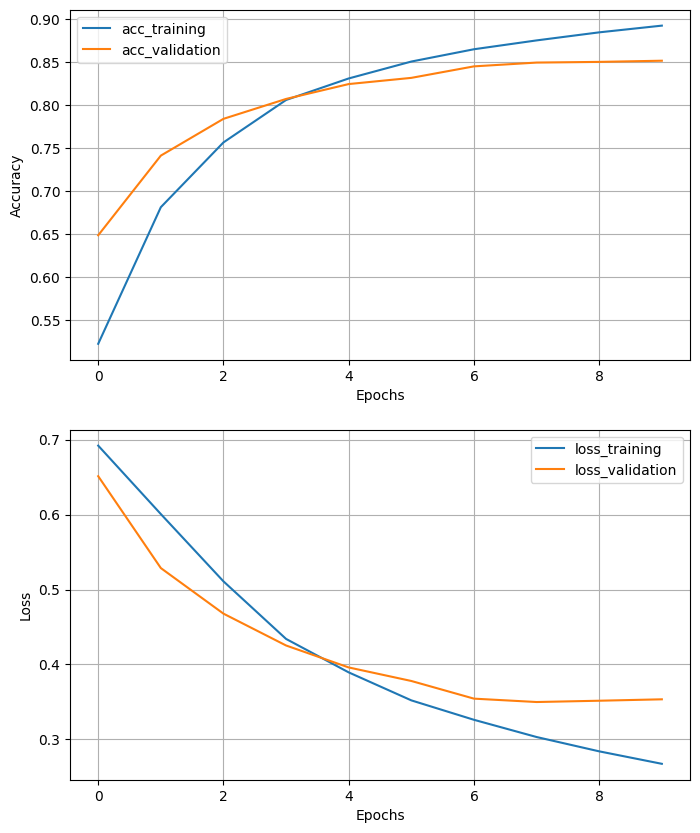

In [28]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

`%ENDCODE`

In [23]:
def test_trns(model, dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (label, text) in enumerate(dataloader_test):
      pre_label = model(text, label)
      loss += criterion(pre_label, label)
      labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
      pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
      total_acc_test += (pre_label == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

`%STARTCODE`

In [29]:
gc.collect()
test_trns(transformer, dataloader_test_trns)

Test Loss: 0.34352875 ---------- Test Accuracy: 85.7360%


`%ENDCODE`